# CHANEL - Rebag dataset: cleaning & EDA

In [1]:
# import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
# this line is needed to display plots in jupyter notebooks
%matplotlib inline
#used to open URLs
import urllib.request
from urllib.request import Request, urlopen
import requests
#used to extract data from html files
from bs4 import BeautifulSoup
from requests import get
import csv
#needed for connection with BigQuery
import os
from google.cloud import bigquery
#location of the keys for BigQuery account
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='FILEPATH TO CREDENTIALS'

Fetching the CHANEL Rebag data from BigQuery
Most of the data cleaning and some feature engineering has already been done in BigQuery.
Here I will just delete some rows I don't need anymore and clean up some more columns and do some EDA

In [2]:
bigquery_client = bigquery.Client()

In [3]:
QUERY = """
SELECT *
FROM `fakebagdetector.LuxValue.RB_CHANEL_clean`
"""

In [4]:
query_job = bigquery_client.query(QUERY)

In [5]:
print(query_job)

In [6]:
df = query_job.to_dataframe()
df.head()

,brand,price,accessories,has_chain,has_quilts,has_logo,color_ext,material,year,size,condition_ext,other_defects,has_smell,style
0,Chanel,1865,No Accessories,NaN,1.0,NaN,metallic,lambskin,1980s,mini,good,NaN,NaN,clutch
1,Chanel,1080,No Accessories,NaN,1.0,NaN,black,fabric,1980s,small,fair,1.0,NaN,clutch
2,Chanel,1905,Authenticity Card,1.0,NaN,NaN,black,lambskin,1980s,small,good,NaN,NaN,clutch
3,Chanel,1650,No Accessories,1.0,NaN,1.0,black,suede,1980s,mini,good,NaN,NaN,clutch
4,Chanel,2030,"Luggage Tag, With Strap",NaN,1.0,NaN,black,lambskin,1980s,xlarge,good,1.0,NaN,clutch


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   brand          990 non-null    object 
 1   price          990 non-null    int64  
 2   accessories    988 non-null    object 
 3   has_chain      449 non-null    float64
 4   has_quilts     597 non-null    float64
 5   has_logo       462 non-null    float64
 6   color_ext      990 non-null    object 
 7   material       990 non-null    object 
 8   year           990 non-null    object 
 9   size           990 non-null    object 
 10  condition_ext  990 non-null    object 
 11  other_defects  128 non-null    float64
 12  has_smell      22 non-null     float64
 13  style          990 non-null    object 
dtypes: float64(5), int64(1), object(8)
memory usage: 108.4+ KB


In [9]:
#count the number of accessories - checked what can be present in bigquery
def get_numacc(row):
    if row.accessories == None or row.accessories == "No Accessories" or "http://" in row.accessories:
        counting = 0
    else:
        counting = 0
        if 'Dust Bag' in row.accessories:
            counting += 1
        if 'Box' in row.accessories:
            counting += 1
        if 'Strap' in row.accessories:
            counting += 1
        if 'Card' in row.accessories:
            counting += 1
        if 'Pochette' in row.accessories:     
            counting += 1
        if 'Charm' in row.accessories:
            counting += 1
        if 'Keys' in row.accessories:
            counting += 1
        if 'Lock' in row.accessories:
            counting += 1
        if 'Tag' in row.accessories:
            counting += 1
        if 'Clochette' in row.accessories:
            counting += 1
        if 'Tassel' in row.accessories:
            counting += 1
        if 'Case' in row.accessories:
            counting += 1
        if 'Mirror' in row.accessories:
            counting += 1
        if 'Holder' in row.accessories:
            counting += 1
        if 'Cover' in row.accessories:
            counting += 1
    return counting    
        
df['acc_included'] = df.apply(get_numacc,axis='columns')
df.drop(['accessories'], axis=1, inplace=True)

In [10]:
df.head()

,brand,price,has_chain,has_quilts,has_logo,color_ext,material,year,size,condition_ext,other_defects,has_smell,style,acc_included
0,Chanel,1865,NaN,1.0,NaN,metallic,lambskin,1980s,mini,good,NaN,NaN,clutch,0
1,Chanel,1080,NaN,1.0,NaN,black,fabric,1980s,small,fair,1.0,NaN,clutch,0
2,Chanel,1905,1.0,NaN,NaN,black,lambskin,1980s,small,good,NaN,NaN,clutch,1
3,Chanel,1650,1.0,NaN,1.0,black,suede,1980s,mini,good,NaN,NaN,clutch,0
4,Chanel,2030,NaN,1.0,NaN,black,lambskin,1980s,xlarge,good,1.0,NaN,clutch,2


In [11]:
#replacing NaN with 0
df.fillna(0, inplace=True)

In [12]:
df = df[['price','year','size','color_ext','material','acc_included','condition_ext','other_defects',
         'has_smell','has_chain','has_logo','has_quilts','style','brand']]
df.head()

,price,year,size,color_ext,material,acc_included,condition_ext,other_defects,has_smell,has_chain,has_logo,has_quilts,style,brand
0,1865,1980s,mini,metallic,lambskin,0,good,0.0,0.0,0.0,0.0,1.0,clutch,Chanel
1,1080,1980s,small,black,fabric,0,fair,1.0,0.0,0.0,0.0,1.0,clutch,Chanel
2,1905,1980s,small,black,lambskin,1,good,0.0,0.0,1.0,0.0,0.0,clutch,Chanel
3,1650,1980s,mini,black,suede,0,good,0.0,0.0,1.0,1.0,0.0,clutch,Chanel
4,2030,1980s,xlarge,black,lambskin,2,good,1.0,0.0,0.0,0.0,1.0,clutch,Chanel


In [13]:
df.rename(columns={'year':'production_year','color_ext':'color','style':'bag_style'}, inplace=True)

In [14]:
df.head()

,price,production_year,size,color,material,acc_included,condition_ext,other_defects,has_smell,has_chain,has_logo,has_quilts,bag_style,brand
0,1865,1980s,mini,metallic,lambskin,0,good,0.0,0.0,0.0,0.0,1.0,clutch,Chanel
1,1080,1980s,small,black,fabric,0,fair,1.0,0.0,0.0,0.0,1.0,clutch,Chanel
2,1905,1980s,small,black,lambskin,1,good,0.0,0.0,1.0,0.0,0.0,clutch,Chanel
3,1650,1980s,mini,black,suede,0,good,0.0,0.0,1.0,1.0,0.0,clutch,Chanel
4,2030,1980s,xlarge,black,lambskin,2,good,1.0,0.0,0.0,0.0,1.0,clutch,Chanel


In [15]:
# putting the clean data in a new csv file
df.to_csv('RBChanel_cleanpd.csv')

## 1. EDA

In [16]:
#reading in the clean dataset
df = pd.read_csv('RBChanel_cleanpd.csv', index_col=0,header=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 990 entries, 0 to 989
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            990 non-null    int64  
 1   production_year  990 non-null    object 
 2   size             990 non-null    object 
 3   color            990 non-null    object 
 4   material         990 non-null    object 
 5   acc_included     990 non-null    int64  
 6   condition_ext    990 non-null    object 
 7   other_defects    990 non-null    float64
 8   has_smell        990 non-null    float64
 9   has_chain        990 non-null    float64
 10  has_logo         990 non-null    float64
 11  has_quilts       990 non-null    float64
 12  bag_style        990 non-null    object 
 13  brand            990 non-null    object 
dtypes: float64(5), int64(2), object(7)
memory usage: 116.0+ KB


In [17]:
# import statements
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
# this line is needed to display plots in jupyter notebooks
%matplotlib inline
plt.style.use('seaborn-whitegrid')
sns.set_style('whitegrid')

### 1.1 Feature distributions 

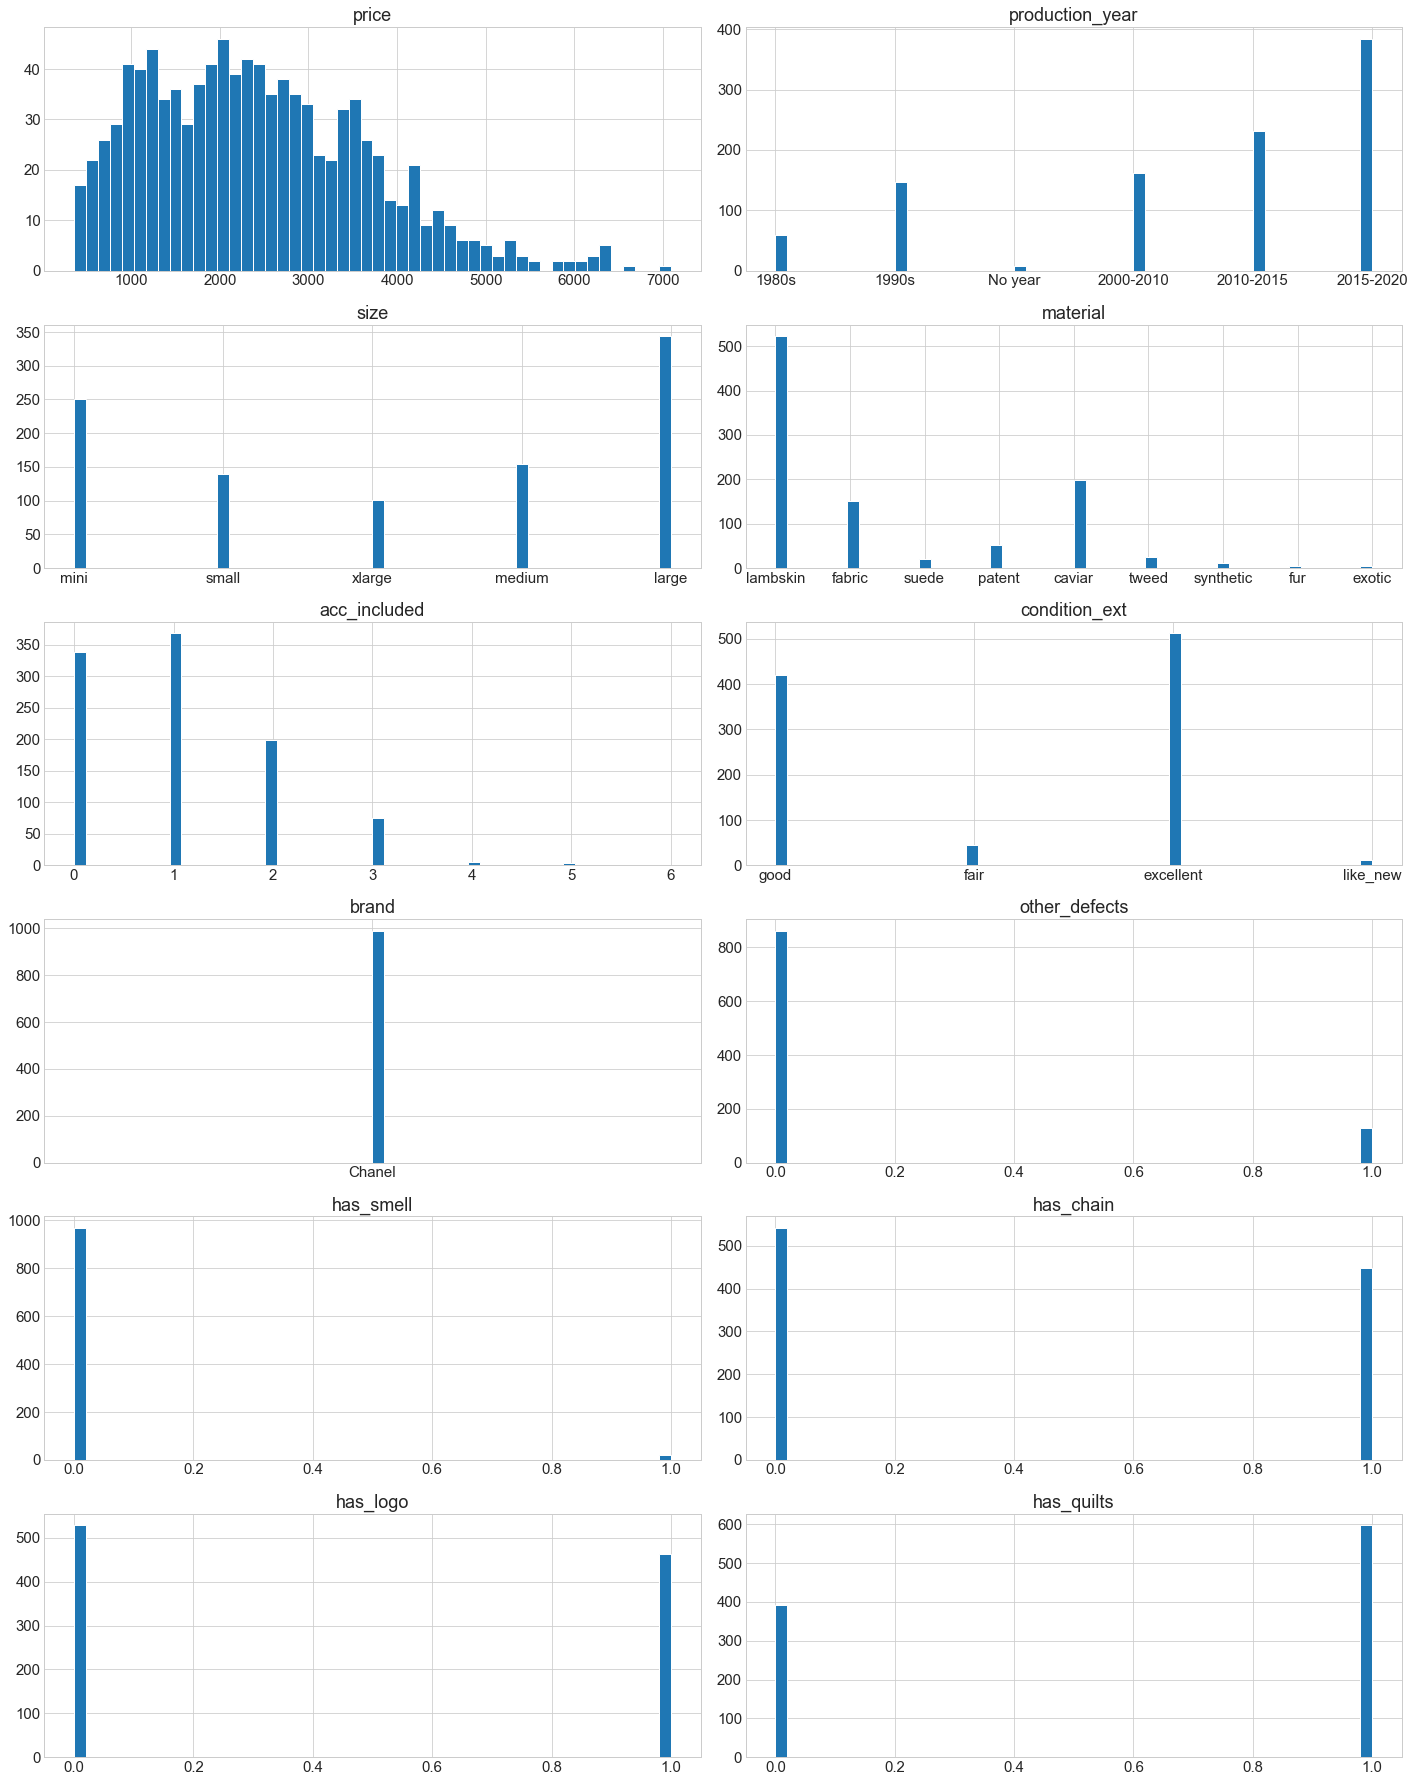

In [18]:
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size']=15

#look at the distribution of the variables
cols = ['price', 'production_year', 'size', 'material', 'acc_included',
       'condition_ext', 'brand', 'other_defects', 'has_smell',
       'has_chain', 'has_logo', 'has_quilts']

fig, axes = plt.subplots(6,2, figsize=(20,25))

for i in range(12):
    ax = axes[i//2][i%2]
    ax.hist(df[cols[i]],bins=50)
    ax.set_title(cols[i])

plt.tight_layout()

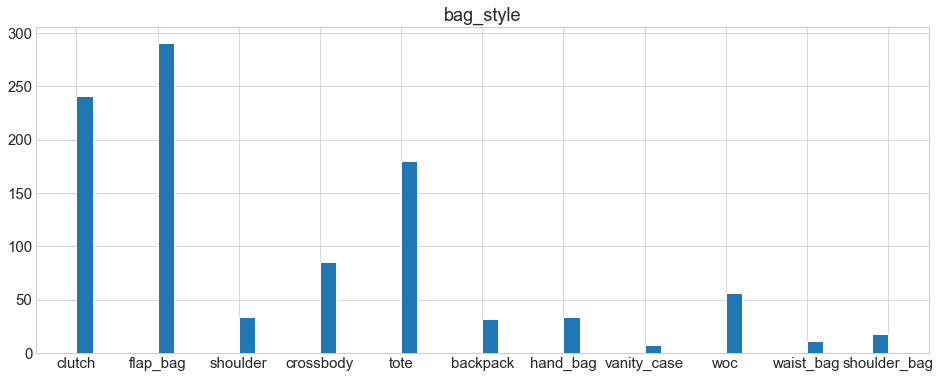

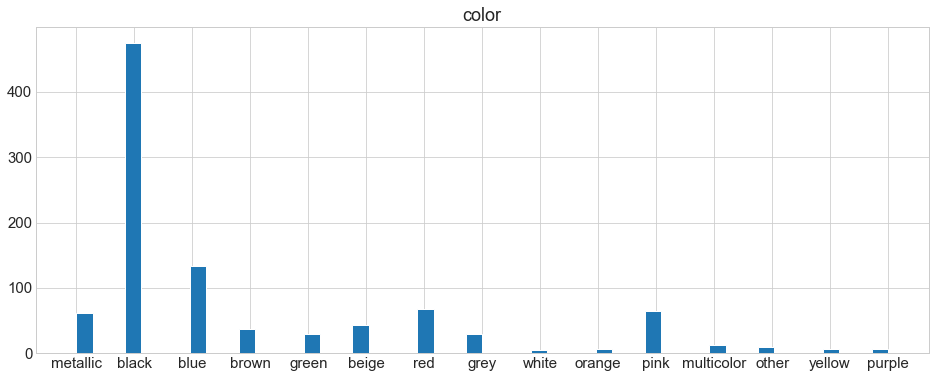

In [19]:
fig = plt.figure(figsize=(16, 6))
x = df['bag_style']
plt.title('bag_style')
_ = plt.hist(x, bins=50)   
    
fig = plt.figure(figsize=(16, 6))
x = df['color']
plt.title('color')
n = plt.hist(x, bins=50)

### 1.2 relationship between target *price* and features

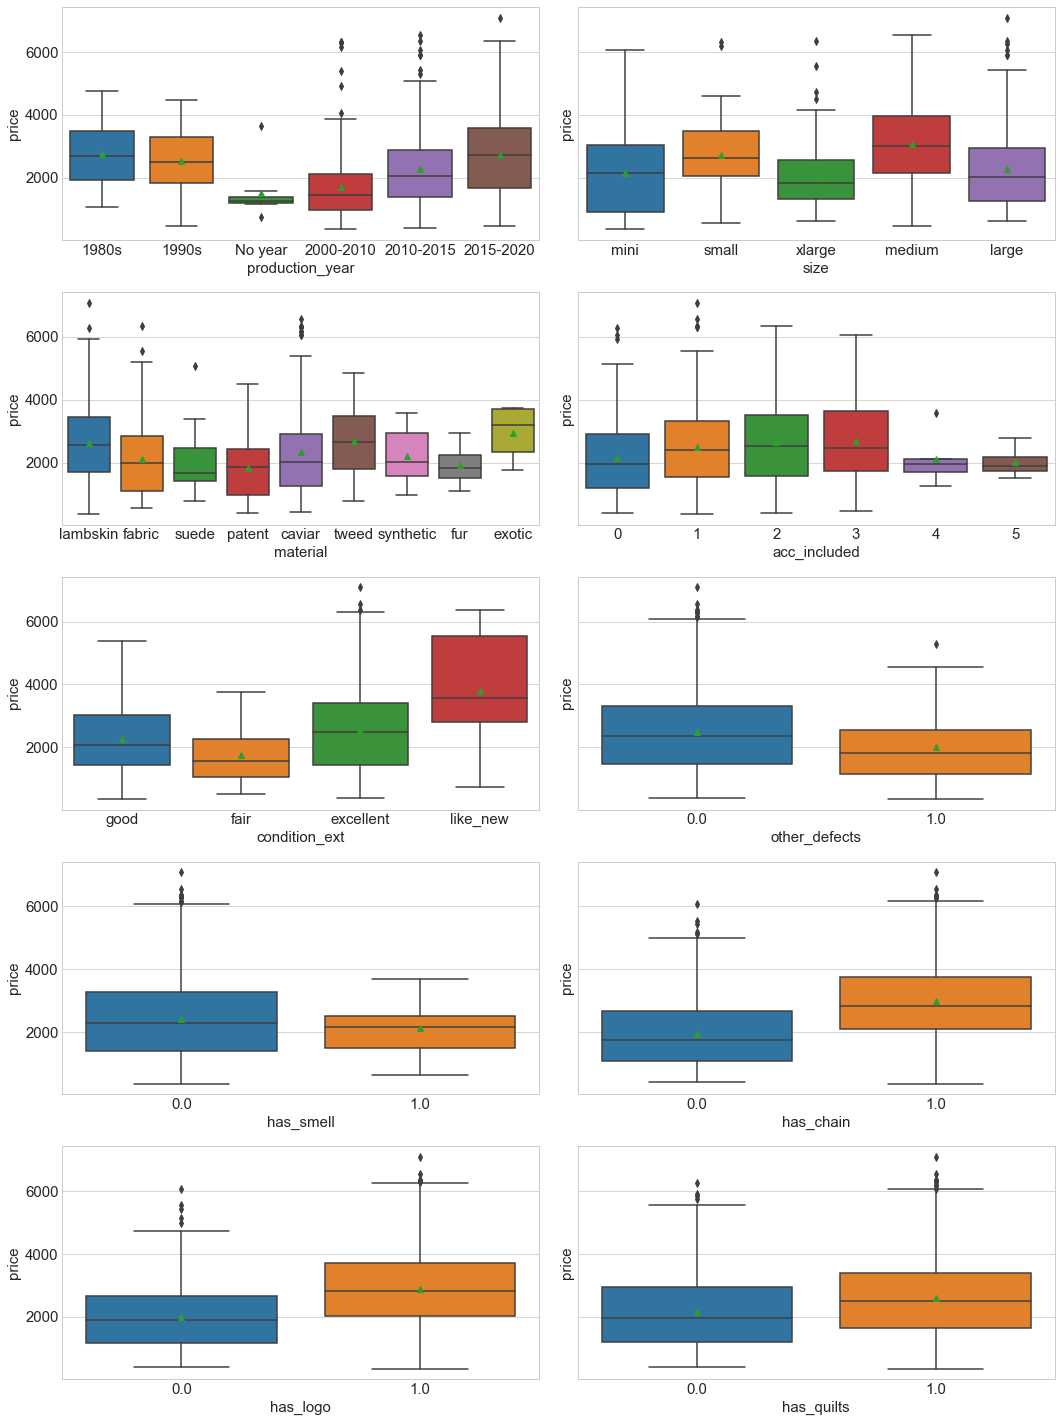

In [20]:
df=df.loc[(df.acc_included<6)]

fig, axes = plt.subplots(5,2, figsize=(15,20), sharey=True)
for xcol, ax in zip(['production_year', 'size', 'material', 'acc_included',
                     'condition_ext', 'other_defects', 'has_smell',
                     'has_chain', 'has_logo', 'has_quilts'], axes.flatten()):
    sns.boxplot(xcol, 'price', data=df, ax=ax,showmeans=True)       
plt.tight_layout()

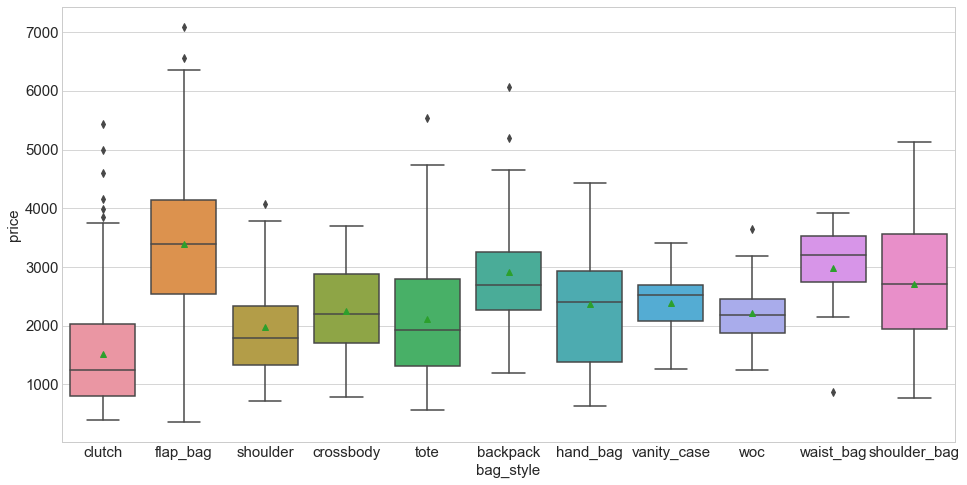

In [21]:
fig = plt.figure(figsize=(16, 8))
sns.boxplot('bag_style', 'price', data=df,showmeans=True)

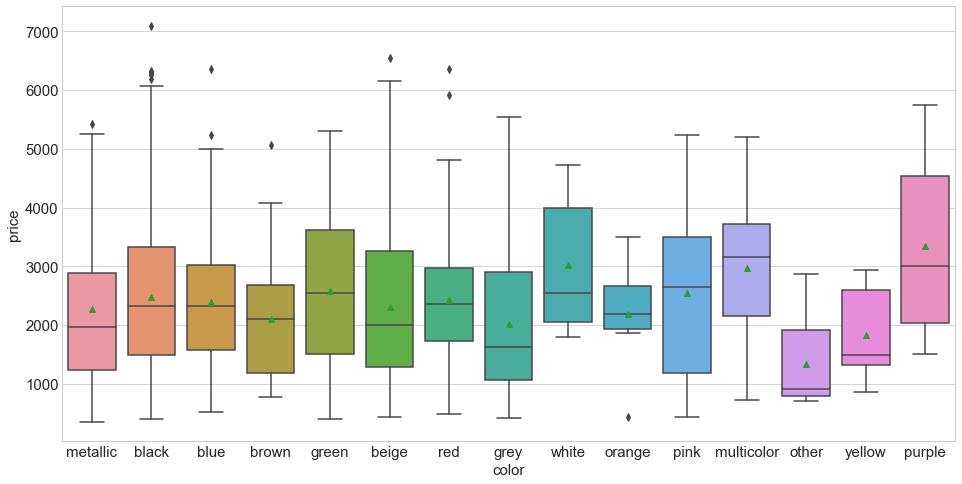

In [22]:
fig = plt.figure(figsize=(16, 8))
sns.boxplot('color', 'price', data=df,showmeans=True)

In [23]:
sizep = df.groupby(['size']).price.mean()
print(sizep)
print('\n')
yearp = df.groupby(['production_year']).price.mean()
print(yearp)
print('\n')
matp = df.groupby(['material']).price.mean()
print(matp)
print('\n')
accp = df.groupby(['acc_included']).price.mean()
print(accp)
print('\n')
extp = df.groupby(['condition_ext']).price.mean()
print(extp)
print('\n')
haschainquilt1 = (df.loc[(df.has_chain==1)&(df.has_quilts==1)]).price.mean()
haschainquilt0 = (df.loc[(df.has_chain==0)&(df.has_quilts==0)]).price.mean()
print('mean price of quilted and has chains: {}'.format(haschainquilt1))
print("mean price of doesn't have quilts and chains: {}".format(haschainquilt0))
print('\n')
isblack = (df.loc[(df.color=='black')]).price.mean()
isred = (df.loc[(df.color=='red')]).price.mean()
isyelorgreen = (df.loc[(df.color=='yellow')|(df.color=='orange')|(df.color=='green')]).price.mean()
print('mean price of black: {}'.format(isblack))
print("mean price of red: {}".format(isred))
print("mean price of yellow, orange or green: {}".format(isyelorgreen))
print('\n')
isflap = (df.loc[(df.bag_style=='flap_bag')]).price.mean()
istote = (df.loc[(df.bag_style=='tote')]).price.mean()
isbumback = (df.loc[(df.bag_style=='vanity_case')|(df.bag_style=='backpack')]).price.mean()
print('mean price of a classic flap: {}'.format(isflap))
print("mean price of a tote: {}".format(istote))
print("mean price of a bum bag or backpack: {}".format(isbumback))
print('\n')

size
large     2280.305233
medium    3076.870968
mini      2150.240964
small     2736.785714
xlarge    2092.772277
Name: price, dtype: float64


production_year
1980s        2758.389831
1990s        2521.190476
2000-2010    1705.652174
2010-2015    2283.181818
2015-2020    2725.091384
No year      1521.875000
Name: price, dtype: float64


material
caviar       2321.909548
exotic       2951.000000
fabric       2110.833333
fur          1923.750000
lambskin     2606.982759
patent       1834.528302
suede        2039.000000
synthetic    2207.727273
tweed        2679.800000
Name: price, dtype: float64


acc_included
0    2142.958580
1    2500.896739
2    2649.170854
3    2676.600000
4    2118.000000
5    2025.000000
Name: price, dtype: float64


condition_ext
excellent    2563.346380
fair         1746.555556
good         2273.859857
like_new     3792.500000
Name: price, dtype: float64


mean price of quilted and has chains: 3084.936102236422
mean price of doesn't have quilts and chains: 1849

In [24]:
isclcavblackflap = (df.loc[(df.color=='black')&(df.bag_style=='flap_bag')&(df.material=='caviar')]).price.mean()
print('mean price of a black caviar classic flap: {}'.format(isclcavblackflap))

mean price of a black caviar classic flap: 4664.5


Some interesting things to notice here:
- the more accessories are included, the more expemisve the bag (~ linear relationship)
- the most recent bags are the most expensive (2015- 2020)
- getting more bag/bang for your buck doesn't hold up here! medium size bags are the most expensive! - and this makes sense for luxury bags, medium sized bags are the most versatile and suitable for any occassion while still big enough to hold all your essentials
- caviar bags have the highest value (caviar is a type of grained leather and the most durable type of leather CHANEL has, hence its popularity...), while patent leather (not durable!) and suede (not durable and loses its luster over time) are the least valued
- A bag having chains, quils, and a logo (=hallmark CHANEL features!) all bumps up the value of the bag
- flap bags (= CHANEL's classic and timeless style) and vanity cases (= very trendy at the moment)are the most valuable styles